#### Установка и импорт необходимых библиотек

In [ ]:
# установка необходимых библиотек
!pip install -r requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_with_heading(heading, data):
    '''
    Функция для красивого отображения
    датафреймов с заголовком сверху
    
    heading — (str) — заголовок
    data — (pandas dataframe) — dataframe
    '''
    
    print(f'{heading}:')
    display(data)

#### Загрузка и предварительное изучение датасета

In [7]:
# загрузка исторических данных

try:
    hist_data = pd.read_csv(
        'datasets/sollmafin_hist.csv',
        parse_dates=[
            'first_ts', 
            'first_dt', 
            'event_ts',
        ]
    )
    
except:
    hist_data = pd.read_csv(
        'https://code.s3.yandex.net/datasets/pa_sollmafin_hist.csv',
        parse_dates=[
            'first_ts', 
            'first_dt', 
            'event_ts',
        ]
    )
    
display_with_heading(
    'Исторические данные',
    hist_data.head()
)

print('Информация о датасете hist_data:\n')
hist_data.info()

Исторические данные:


,user_id,country_code,platform,first_ts,first_dt,event_ts,event_name,amount,asset,risk_level
0,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 19:55:51,install / open_web,NaN,NaN,NaN
1,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 19:55:59,introduction,NaN,NaN,NaN
2,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:46:06,registration,NaN,NaN,NaN
3,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:46:15,main_page,NaN,NaN,NaN
4,548ac59f-656d-4110-80d2-49f0a217f08a,BR,mobile,2025-04-02 19:55:51,2025-04-02,2025-04-02 23:47:59,onboarding_complete,NaN,NaN,NaN


Информация о датасете hist_data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238059 entries, 0 to 238058
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       238059 non-null  object        
 1   country_code  238059 non-null  object        
 2   platform      238059 non-null  object        
 3   first_ts      238059 non-null  datetime64[ns]
 4   first_dt      238059 non-null  datetime64[ns]
 5   event_ts      238059 non-null  datetime64[ns]
 6   event_name    238059 non-null  object        
 7   amount        33093 non-null   float64       
 8   asset         15392 non-null   object        
 9   risk_level    15392 non-null   object        
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 18.2+ MB


**Промежуточный вывод:** 
- на первый взгляд данные соответствуют описанию, но нужно посмотреть на уникальные значения в столбцах с категорийными переменными, а также на диапазоны значений в столбцах с переменными численного типа и датами
- типы данных подходящие
- есть пропуски в столбцах `amount`, `asset`, `risk_level`, но пропуски объяснимы смыслом столбцов

In [8]:
# посмотрим на значения в
# столбцах с категорийными переменными

category_columns = [
    'country_code', 'platform', 
    'event_name', 'asset', 'risk_level'
]

for column in category_columns:
    display_with_heading(
        f'Уникальные значения столбца {column}',
        list(hist_data[column].unique())
    )
    print('\n')

Уникальные значения столбца country_code:


['BR', 'AR', 'CO', 'MX']



Уникальные значения столбца platform:


['mobile', 'web']



Уникальные значения столбца event_name:


['install / open_web',
 'introduction',
 'registration',
 'main_page',
 'onboarding_complete',
 'first_deposit',
 'asset_purchase',
 'second_deposit']



Уникальные значения столбца asset:


[nan, 'stock', 'option', 'crypto']



Уникальные значения столбца risk_level:


[nan, 'medium', 'high', 'low']

In [10]:
# посмотрим на наличие дубликатов в датафрейме

print(
    'Кол-во полных дубликатов в датафрейме:',
    hist_data.duplicated().sum()
)

Кол-во полных дубликатов в датафрейме: 0


#### Вывод по загрузке и предварительному изучению датасета
- данные и их типы соответствуют описанию и бизнес-контексту
- полных дубликатов нет
- в ряде столбцов есть пропуски, но они объяснимы

### Исследовательский анализ данных

1. Динамика кол-ва новых пользователей
2. Воронка по ключевым пользовательским событиям
3. Влияние уровня риска актива на совершение повторного депозита

Изучим данные и вынесем наблюдаемые факты в промежуточные выводы, затем сформируем по ним предположения относительно поведения пользователей

#### 1. Динамика кол-ва новых пользователей

Первое, что делает пользователь — скачивает приложение или открывает веб-версию. В столбце `event_name` эти события называются *install / open_web*. Поэтому для анализа динамики новых пользователей рассчитаем кол-во скачиваний по дням

In [11]:
# отфильтруем датафрейм, оставив 
# только события скачивания

hist_data_install = (
    hist_data[
        hist_data.event_name == 'install / open_web'
    ]
)

# рассчитаем кол-во скачиваний
# по дням

hist_data_install_daily = (
    hist_data_install
        .groupby('first_dt')
        .agg(new_users=('user_id', 'nunique'))
        .reset_index()
)

display_with_heading(
    'Кол-во новых пользователей по дням',
    hist_data_install_daily.head()
)

display_with_heading(
    'Описательные статистики параметра "Кол-во новых пользователей в день"',
    hist_data_install_daily.new_users.describe()
)

Кол-во новых пользователей по дням:


,first_dt,new_users
0,2025-04-01,670
1,2025-04-02,676
2,2025-04-03,691
3,2025-04-04,637
4,2025-04-05,640


Описательные статистики параметра "Кол-во новых пользователей в день":


count     62.000000
mean     661.806452
std       23.425388
min      613.000000
25%      646.500000
50%      663.000000
75%      682.750000
max      713.000000
Name: new_users, dtype: float64

**Промежуточный вывод:** среднее значение кол-ва скачиваний в день составляет около 660, стандартное отклонение невысокое — 23. Т.е. кол-во скачиваний на исторических данных достаточно стабильно

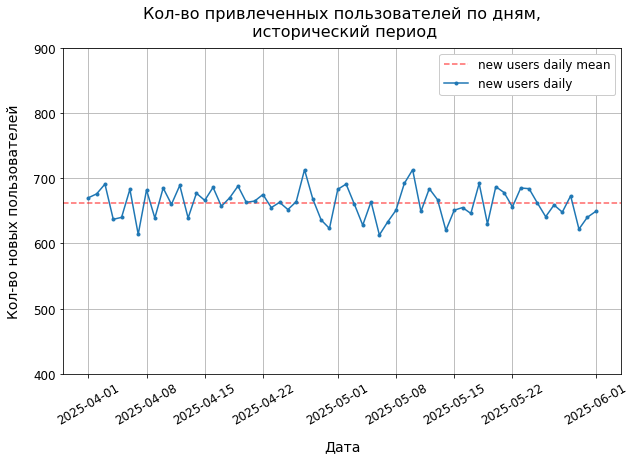

In [17]:
# визуализация

plt.figure(figsize=(10,6))

# среднее значение на исторических 
# данных
plt.axhline(
    hist_data_install_daily.new_users.mean(),
    linestyle='dashed',
    color='red',
    alpha=0.6,
    label='new users daily mean'
)

plt.plot(
    hist_data_install_daily.first_dt,
    hist_data_install_daily.new_users,
    marker='.',
    label='new users daily'
)

plt.ylim(400, 900)

plt.title(
    'Кол-во привлеченных пользователей по дням,'
    + '\n исторический период',
    fontsize=16,
    pad=12,
)

plt.xlabel(
    'Дата',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Кол-во новых пользователей',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

plt.grid()

plt.legend(
    fontsize=12,
    framealpha=1,
)

plt.xticks(rotation=30)

plt.show()

##### Также проведем сегментацию по платформе (*mobile* / *web*) и географии пользователя (*BR* / *MX* / *CO* / *AR*)


Описательные статистики параметра "Кол-во новых пользователей в день":, mobile-платформа:


count     62.000000
mean     463.838710
std       21.826584
min      416.000000
25%      450.250000
50%      463.000000
75%      478.750000
max      529.000000
Name: new_users, dtype: float64


Описательные статистики параметра "Кол-во новых пользователей в день":, web-платформа:


count     62.000000
mean     197.967742
std       14.149052
min      160.000000
25%      193.000000
50%      197.000000
75%      204.000000
max      246.000000
Name: new_users, dtype: float64

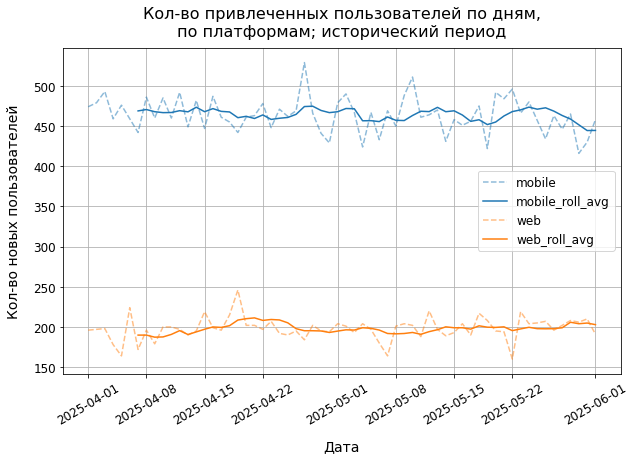

In [27]:
# по платформам
hist_data_install_pl = (
    hist_data[
        hist_data.event_name == 'install / open_web'
    ]
)

hist_data_install_pl_daily = (
    hist_data_install_pl
        .groupby(['first_dt', 'platform'])
        .agg(new_users=('user_id', 'nunique'))
        .reset_index()
)

# визуализация
platforms = hist_data.platform.unique()
colors = ['tab:blue', 'tab:orange']

plt.figure(figsize=(10,6))

for i, platform in enumerate(platforms):
    data_for_plot = (
        hist_data_install_pl_daily[
            hist_data_install_pl_daily['platform'] == platform
        ]
    )
    
    display_with_heading(
        '\nОписательные статистики параметра'
        +' "Кол-во новых пользователей в день":,'
        +f' {platform}-платформа',
        data_for_plot.new_users.describe()
    )
    
    data_for_plot['7_day_rolling_avg'] = data_for_plot.new_users.rolling(7).mean()

    plt.plot(
        data_for_plot.first_dt,
        data_for_plot.new_users,
        color=colors[i],
        linestyle='--',
        alpha=0.5,
        label=platform
    )
    
    plt.plot(
        data_for_plot.first_dt,
        data_for_plot['7_day_rolling_avg'],
        color=colors[i],
        alpha=1,
        label=f'{platform}_roll_avg'
    )

plt.title(
    'Кол-во привлеченных пользователей по дням,'
    + '\nпо платформам; исторический период',
    fontsize=16,
    pad=12,
)

plt.xlabel(
    'Дата',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Кол-во новых пользователей',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

plt.grid()
plt.legend(fontsize=12)
plt.xticks(rotation=30)

plt.show()

**Промежуточный вывод:** клиенты намного чаще приходят с мобильной (~ 460 пользователей в день), нежели веб-версии (~ 200 пользователей в день); приток клиентов с обеих платформ стабилен

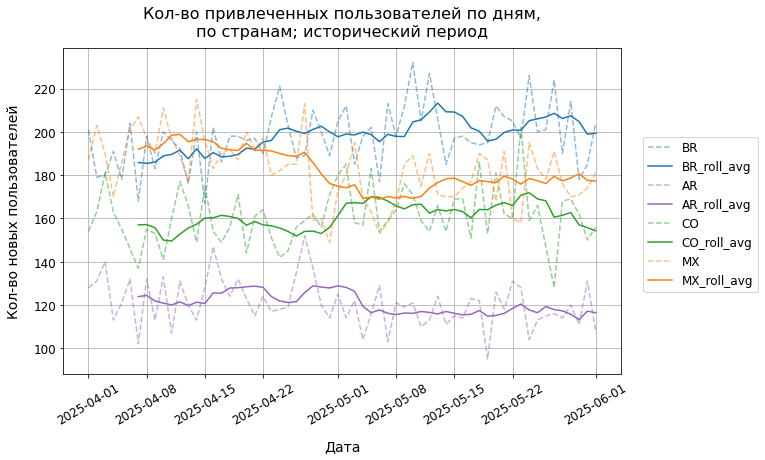

In [33]:
# по странам
hist_data_install_geo = (
    hist_data[
        hist_data.event_name == 'install / open_web'
    ]
)

hist_data_install_geo_daily = (
    hist_data_install_geo
        .groupby(['first_dt', 'country_code'])
        .agg(new_users=('user_id', 'nunique'))
        .reset_index()
)

# визуализация
country_codes = hist_data.country_code.unique()
colors = ['tab:blue', 'tab:purple', 'tab:green', 'tab:orange']

plt.figure(figsize=(10,6))

for i, country_code in enumerate(country_codes):
    data_for_plot = (
        hist_data_install_geo_daily[
            hist_data_install_geo_daily['country_code'] == country_code
        ]
    )
    
    data_for_plot['7_day_rolling_avg'] = data_for_plot.new_users.rolling(7).mean()

    plt.plot(
        data_for_plot.first_dt,
        data_for_plot.new_users,
        color=colors[i],
        linestyle='--',
        alpha=0.5,
        label=country_code
    )
    
    plt.plot(
        data_for_plot.first_dt,
        data_for_plot['7_day_rolling_avg'],
        color=colors[i],
        alpha=1,
        label=f'{country_code}_roll_avg'
    )

plt.title(
    'Кол-во привлеченных пользователей по дням,'
    + '\nпо странам; исторический период',
    fontsize=16,
    pad=12,
)

plt.xlabel(
    'Дата',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Кол-во новых пользователей',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

plt.grid()
plt.legend(
    fontsize=12,
    loc=(1.04, 0.25)
)
plt.xticks(rotation=30)

plt.show()

#### Вывод по анализу динамики кол-ва новых пользователей
- **кол-во скачиваний стабильно**, составляет ~660 в день
- клиенты чаще приходят с мобильной, нежели веб-версии; приток клиентов с обеих платформ стабилен
- наибольшее кол-во пользователей из Бразилии, наименьшее — из Аргентины

#### 2. Воронка ключевых пользовательских событий

Датасет подготовлен к постоению воронок, т.к. уже содержит информацию по ключевым пользовательским событиям от скачивания приложения до совершения второго депозита с заданным окном атрибуции. Построим классическую и пошаговую воронки, чтобы изучить путь пользователей в приложении и найти "узкие" места

Сначала выберем пользователя, дошедшего до шага совершения второго депозита, чтобы зафиксировать порядок событий

In [43]:
# выберем пользователя
example_user_id = (
    hist_data[
        hist_data['event_name']=='second_deposit'
    ]['user_id'].iloc[0]
)

# отфильтруем датафрейм по выбранному
# пользователю, отсорируем по времени
# события 
events_order = list(
    hist_data[hist_data.user_id == example_user_id]
        .sort_values('event_ts')
        .event_name
)

display_with_heading(
    'Порядок событий',
    events_order
)

Порядок событий:


['install / open_web',
 'introduction',
 'registration',
 'main_page',
 'onboarding_complete',
 'first_deposit',
 'asset_purchase',
 'second_deposit']

In [44]:
# кол-во уникальных пользователей
# на каждом из этапов
hist_data_events_gr = (
    hist_data
        .groupby('event_name')
        .agg(total_users=('user_id', 'nunique'))
        .reindex(events_order)
        .reset_index()
)

# классическая воронка
hist_data_events_gr['users_%_from_first'] = round(
    100 * hist_data_events_gr['total_users'] 
    / hist_data_events_gr['total_users'].iloc[0], 1
)

# пошаговая воронка
hist_data_events_gr['users_%_from_prev'] = round(
    100 * hist_data_events_gr['total_users'] 
    / hist_data_events_gr['total_users'].shift(1), 1
)

display_with_heading(
    'Воронка классическая, пошаговая',
    hist_data_events_gr
)

Воронка классическая, пошаговая:


,event_name,total_users,users_%_from_first,users_%_from_prev
0,install / open_web,41032,100.0,NaN
1,introduction,41032,100.0,100.0
2,registration,38133,92.9,92.9
3,main_page,35040,85.4,91.9
4,onboarding_complete,34337,83.7,98.0
5,first_deposit,27685,67.5,80.6
6,asset_purchase,15392,37.5,55.6
7,second_deposit,5408,13.2,35.1


**Промежуточный вывод:**
1. Этапы взаимодействия с продуктом до завершения онбординга включительно вопросов не вызывают (от этапа к этапу теряется не более 10% пользователей). До завершения онбординга доходит ~ 84% пользователей, установивших приложение; 
2. Первая "просадка" в кол-ве пользователей происходит на этапе совершания первого депозита: от предыдущего этапа (этапа завершения онбординга) теряется около 20% пользователей. От всех пользователей, установивших приложение, до этого этапа доходит примерно две трети пользователей (~ 68%)
3. Следующая, более значительная потеря пользователей, происходит на этапе покупки активов: на этот этап с предыдущего приходит около половины пользователей (теряется ~ 45%). От всех пользователей, установивших приложение, до этого этапа доходит чуть больше трети пользователей (~ 38%)
4. Еще меньше пользователей доходят от этапа покупки актива до этапа совершения второго депозита: приходит треть пользователей (теряется ~ 65% пользователей). От всех пользователей, установивших приложение, до этого этапа доходит менее четверти пользователей (~ 13%)

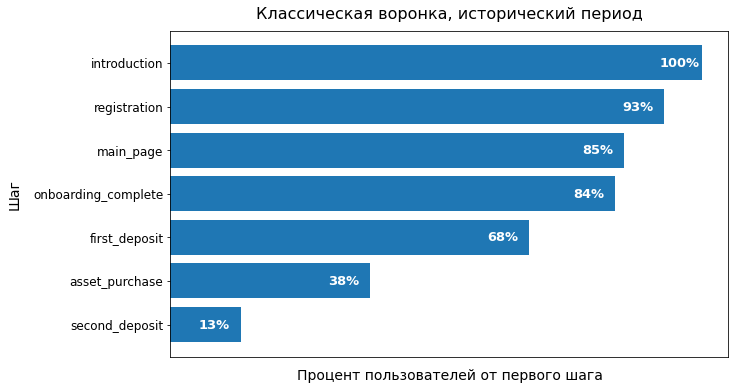

In [49]:
# визуализируем классическую воронку
plt.figure(figsize=(10,6))

plt.barh(
    hist_data_events_gr['event_name'][:0:-1],
    hist_data_events_gr['users_%_from_first'][:0:-1]
)

plt.title(
    'Классическая воронка, исторический период',
    fontsize=16,
    pad=12,
)

plt.xticks([])

plt.xlabel(
    'Процент пользователей от первого шага',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Шаг',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

# добавление значений
for x, y in zip(
    hist_data_events_gr['users_%_from_first'][:0:-1],
    hist_data_events_gr['event_name'][:0:-1]
):
    
    plt.annotate(
        str(round(x))+'%',
        (x,y),
        textcoords="offset points",
        xytext=(-42,0),
        va='center',
        fontsize=13,
        color='white',
        weight='bold'
    )

plt.show()

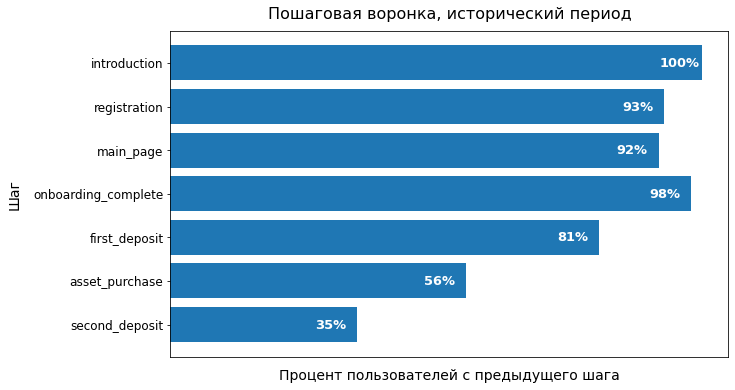

In [50]:
# визуализируем пошаговую воронку
plt.figure(figsize=(10,6))

plt.barh(
    hist_data_events_gr['event_name'][:0:-1],
    hist_data_events_gr['users_%_from_prev'][:0:-1]
)

plt.title(
    'Пошаговая воронка, исторический период',
    fontsize=16,
    pad=12,
)

plt.xticks([])

plt.xlabel(
    'Процент пользователей с предыдущего шага',
    fontsize=14,
    labelpad=12,
)

plt.ylabel(
    'Шаг',
    fontsize=14,
    labelpad=12,
)

plt.tick_params(
   labelsize=12 
)

# добавление значений
for x, y in zip(
    hist_data_events_gr['users_%_from_prev'][:0:-1],
    hist_data_events_gr['event_name'][:0:-1]
):
    
    plt.annotate(
        str(round(x))+'%',
        (x,y),
        textcoords="offset points",
        xytext=(-42,0),
        va='center',
        fontsize=13,
        color='white',
        weight='bold'
    )

plt.show()

#### Вывод по анализу воронки ключевых событий:

**Узкие места воронки** находятся в нижней части:
- **покупка активов** (доходит около половины пользователей, совершивших первый депозит)
- **совершение повторного депозита** (доходит около трети пользователей, совершивших покупку актива)

#### 3. Влияние уровня риска актива на совершение повторного депозита

Особенность данных: пользователи, как правило, покупают только один актив перед совершением повторного депозита. Проведем сегментацию по признаку *risk_level*, затем проверим, что между группами нет пересечений. Затем рассчитаем конверсию в совершение повторного депозита по группам

In [60]:
# отфильтруем данные по имени события
# 'asset_purchase'
hist_data_risk = (
    hist_data[
        hist_data.event_name == 'asset_purchase'
    ][['user_id', 'risk_level']]
)

# создадим словарь в котором будем
# хранить id пользователей
dict_user_groups = {}

risk_levels = ['low', 'medium', 'high']

for risk_level in risk_levels:
    users = (
        hist_data_risk[
            hist_data_risk.risk_level == risk_level
        ]
    )

    dict_user_groups[risk_level] = users.user_id.unique().tolist()

In [61]:
# проверим, что нет пересечения групп
for i in range (len(risk_levels)):
    for j in range(i + 1, len(risk_levels)):
        level_1 = risk_levels[i]
        level_2 = risk_levels[j]
        
        intersection = (
            set(dict_user_groups[level_1])
            & (set(dict_user_groups[level_2]))
        )
        
        if intersection:
            print(f'Есть одинаковые пользователи в {level_1}-risk группе и {level_2}-risk группе')
        else:
            print(f'Нет одинаковых пользователей в {level_1}-risk группе и {level_2}-risk группе')

Нет одинаковых пользователей в low-risk группе и medium-risk группе
Нет одинаковых пользователей в low-risk группе и high-risk группе
Нет одинаковых пользователей в medium-risk группе и high-risk группе


In [64]:
# рассчитаем конверсию в повторный
# депозит от уровня риска актива
conv_dict = {}

for risk_level in risk_levels:
    conv_data = (
        hist_data[
            (hist_data.user_id.isin(dict_user_groups[risk_level]))
            & (hist_data.event_name.isin(['asset_purchase', 'second_deposit']))
        ]
    )
    
    total_users = (
        conv_data
            .groupby('event_name')
            .agg(total_users=('user_id', 'nunique'))
    )
    
    print(
        f'\nУровень риска: {risk_level}'
        +'\nКол-во пользователей:',
        total_users.loc['asset_purchase']['total_users']
    )
    
    conv_dict[risk_level] = round(
        100 * total_users.loc['second_deposit']['total_users']
        / total_users.loc['asset_purchase']['total_users'], 1
    )

conv_df = pd.DataFrame.from_dict(
    conv_dict, 
    orient='index', 
    columns=['CR, %']
)

display_with_heading(
    '\nКонверсия в повторный депозит от уровня риска купленного актива',
    conv_df
)


Уровень риска: low
Кол-во пользователей: 2327

Уровень риска: medium
Кол-во пользователей: 5325

Уровень риска: high
Кол-во пользователей: 7740

Конверсия в повторный депозит от уровня риска купленного актива:


,"CR, %"
low,46.4
medium,43.0
high,26.4


#### Вывод по анализу зависимости конверсии в совершение повторного депозита от уровня риска купленного актива

**Около половины пользователей начинают с покупки высокорискованных активов**, около трети пользователей покупают активы среднего риска

Конверсия в открытие второго депозита составляет более 40% при покупке актива низкого (46%) или среднего (43%) уровня риска, и всего лишь 26% при покупке актива высокого риска

Наиболее **низкую конверсию в повторное совершение депозита** наблюдаем среди пользователей, купивших **активы высокого риска**

### Вывод по исследовательскому анализу данных

Учитывая, что целевая аудитория приложения — начинающие инвесторы, низкая конверсия в покупку активов и совершение повторного депозита объяснима 

На основе исследовательского анализа данных можем выдвинуть следующие предположения:
- пользователи сомневаются при выборе актива, поэтому не совершают покупку
- многие пользователи не понимают, как работать с активами разной степени риска, поэтому покупают высокорискованные активы
- после покупки высокорискованных активов пользователи теряют деньги, поэтому не совершают повторный депозит